# ARIMA model forecast

In [79]:
import pandas as pd
import numpy as np
from datetime import datetime

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 5

import warnings

# FEDOT framework
from fedot.core.data.data import InputData
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams
from fedot.core.data.data_split import train_test_data_setup

import statsmodels.api as sm
from scipy import stats
from itertools import product
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_absolute_error

To install FEDOT, run the following command

In [ ]:
pip install fedot==0.4.1

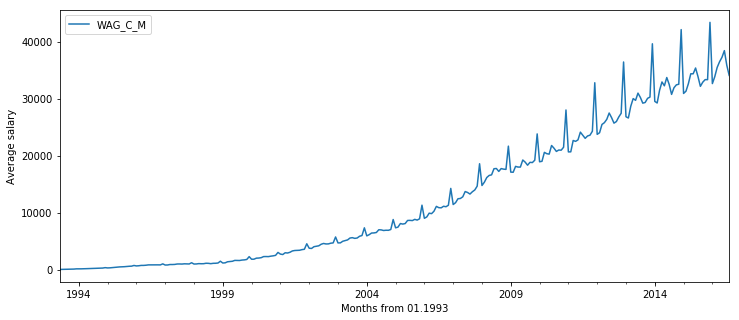

In [19]:
# read the data
wag_df = pd.read_csv('data\salary.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True,encoding='cp1251',engine='python')

wag_df.plot()
plt.ylabel(u'Average salary')
plt.xlabel(u'Months from 01.1993')
plt.show()

In [20]:
wag_df.WAG_C_M.head(2)

month
1993-05-01    37.5
1993-06-01    47.4
Name: WAG_C_M, dtype: float64

Dickey-Fuller test: p=0.991667
Student test: p=0.000000


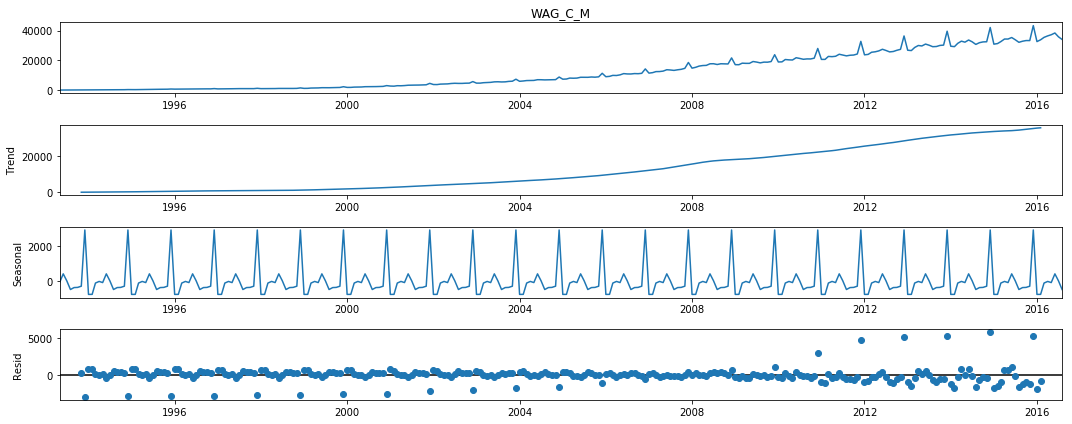

In [21]:
rcParams['figure.figsize'] = 15, 6

sm.tsa.seasonal_decompose(wag_df.WAG_C_M).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wag_df.WAG_C_M)[1])
print("Student test: p=%f" % stats.ttest_1samp(wag_df.WAG_C_M, 0)[1])

## Box–Cox transformation

Best Box-Cox parameter: 0.257063
Dickey-Fuller test: p=0.688484


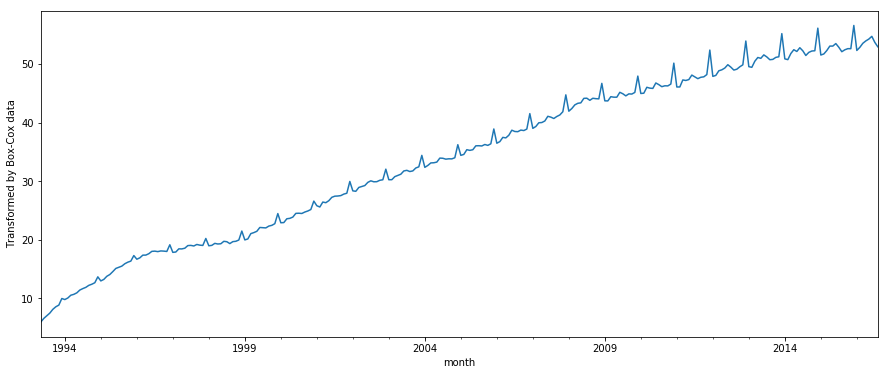

In [69]:
wag_df['WAG_C_M_box'], lmbda = stats.boxcox(wag_df.WAG_C_M)
wag_df.WAG_C_M_box.plot()

plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wag_df.WAG_C_M_box)[1])

## Season-based differentition for the 12 months - 12 step shift

Dickey-Fuller test: p=0.033416


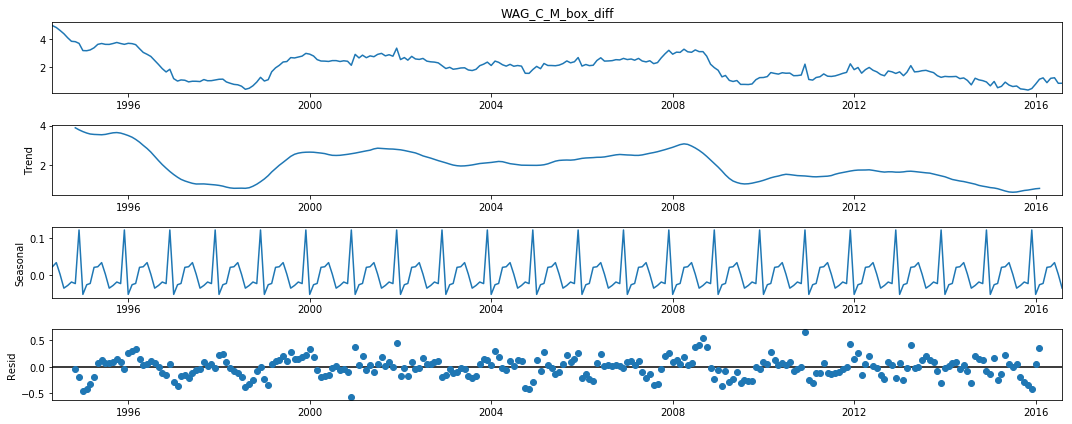

In [70]:
wag_df['WAG_C_M_box_diff']  = wag_df.WAG_C_M_box - wag_df.WAG_C_M_box.shift(12)

sm.tsa.seasonal_decompose(wag_df.WAG_C_M_box_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(wag_df.WAG_C_M_box_diff[12:])[1])

## Additional one-step differencing

Dickey-Fuller test: p=0.000000791458638


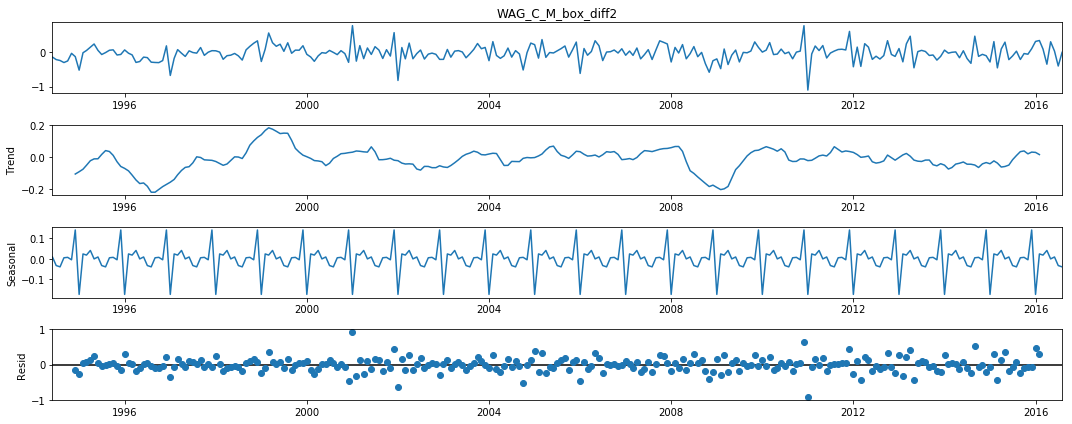

In [71]:
wag_df['WAG_C_M_box_diff2'] = wag_df.WAG_C_M_box_diff - wag_df.WAG_C_M_box_diff.shift(1)

sm.tsa.seasonal_decompose(wag_df.WAG_C_M_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(wag_df.WAG_C_M_box_diff2[13:])[1])

## Autocorrelation and partial autocorrelation

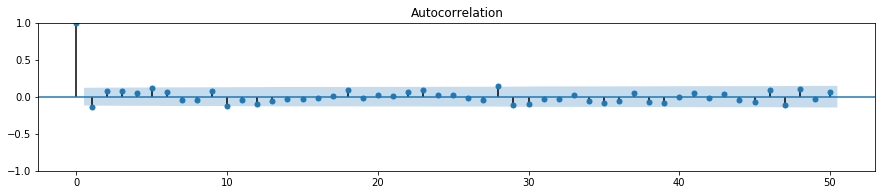

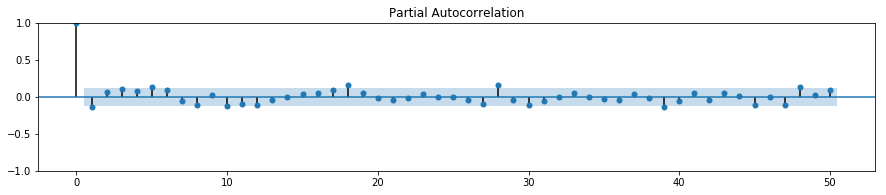

In [74]:
# autocorrelcation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wag_df.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wag_df.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
plt.show()

## FEDOT data preparation

In [15]:
# Convert into numpy array first
time_series = np.array(wag_df['WAG_C_M'])

# Define task - time series forecasting
# and forecast horizon 
task = Task(TaskTypesEnum.ts_forecasting,
                TsForecastingParams(forecast_length=36))

input_data = InputData(idx=np.arange(0, len(time_series)),
                       features=time_series, target=time_series,
                       task=task, data_type=DataTypesEnum.ts)

Train test split

In [22]:
train, test = train_test_data_setup(input_data)

## AR model

In [53]:
pipeline = Pipeline(PrimaryNode('ar'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=500, timeout=5,
                                        cv_folds=3, validation_blocks=2)

Start pipeline tuning
Hyperparameters optimization start
100%|█████████████████████████████████████████████████████| 500/500 [00:03<00:00, 135.41trial/s, best loss: 10000000.0]
Hyperparameters optimization finished
Return init pipeline due to the fact that obtained metric 10000000.000 bigger than initial (+ 5% deviation) 4208.997
Tuning was finished


Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


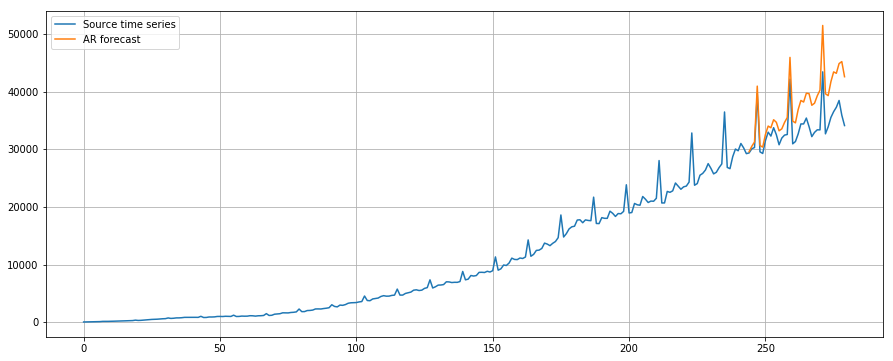

In [54]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='AR forecast')
plt.grid()
plt.legend()
plt.show()

In [55]:
pipeline.print_structure()

Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [ar]}
ar - {'lag_1': 7, 'lag_2': 12}


## Tuning 1. ARIMA model

In [61]:
pipeline = Pipeline(PrimaryNode('arima'))
pipeline = pipeline.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                        loss_params=None, input_data=train,
                                        iterations=100, timeout=5,
                                        cv_folds=2, validation_blocks=2)

Start pipeline tuning
Hyperparameters optimization start
100%|███████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33trial/s, best loss: 1388.202245184366]
Hyperparameters optimization finished
Return tuned pipeline due to the fact that obtained metric 1388.202 equal or smaller than initial (+ 5% deviation) 4444.952
Tuning was finished


In [62]:
fitted_vals = pipeline.fit(train)
forecast = pipeline.predict(test)

Trained operation is not actual because you are using new dataset for training. Parameter use_fitted value changed to False


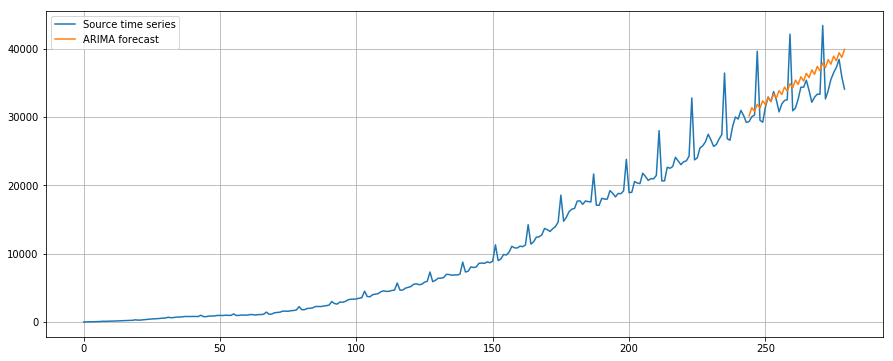

In [63]:
plt.plot(input_data.idx, input_data.target, label='Source time series')
plt.plot(forecast.idx, np.ravel(forecast.predict), label='ARIMA forecast')
plt.grid()
plt.legend()
plt.show()

In [64]:
pipeline.print_structure()

Pipeline structure:
{'depth': 1, 'length': 1, 'nodes': [arima]}
arima - {'p': 2, 'd': 1, 'q': 4}


Not a very good result. Let's try a different setup for the ARIMA-like model

## Tuning 2. SARIMA and AIC

In [77]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs= range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print (u"Models to analyse by AIC:", len(parameters_list))

Models to analyse by AIC: 72


In [81]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(wag_df.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
            continue
    aic = model.aic

    # save best model, aic, parameters
    if (aic < best_aic):
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
print(f'AIC value: {model.aic}')

AIC value: -51.99595620650277


In [82]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
69  (5, 4, 1, 0) -54.134443
59  (4, 5, 1, 0) -53.331169
71  (5, 5, 1, 0) -51.995956
68  (5, 4, 0, 0) -51.583971
29  (2, 2, 1, 0) -49.074863


In [83]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  280
Model:             SARIMAX(5, 1, 4)x(1, 1, [], 12)   Log Likelihood                  38.067
Date:                             Fri, 22 Oct 2021   AIC                            -54.134
Time:                                     18:51:06   BIC                            -14.675
Sample:                                 05-01-1993   HQIC                           -38.284
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6600      0.077      8.526      0.000       0.508       0.812
ar.L2         -0.3986      

## Inverse Box–Cox transformation

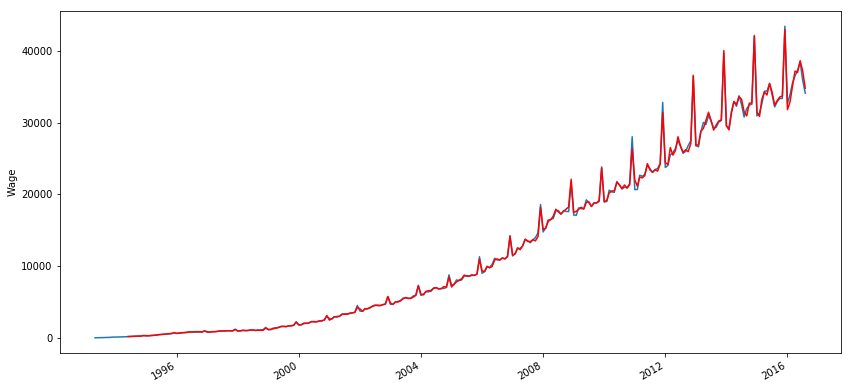

In [96]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
# visualise and compare  
wag_df['model'] = invboxcox(best_model.fittedvalues, lmbda)

rcParams['figure.figsize'] = 14, 7

wag_df.WAG_C_M.plot()
wag_df.model[13:].plot(color='r')
plt.ylabel('Wage')
plt.show()

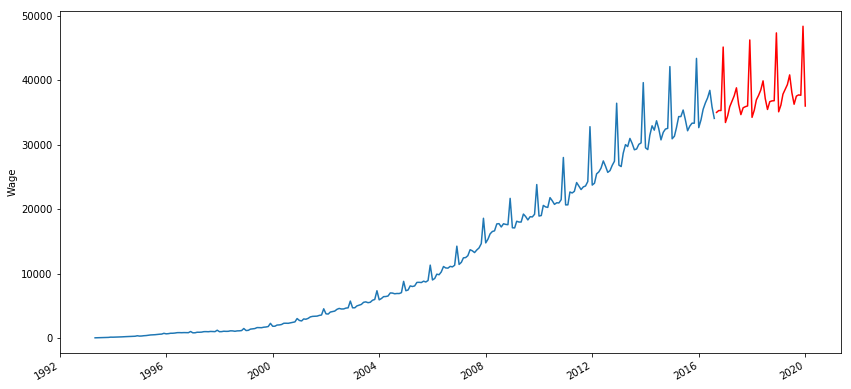

In [98]:
from dateutil.relativedelta import relativedelta

wag_df = wag_df[['WAG_C_M']]
date_list = [datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= wag_df.columns)
wag_df = pd.concat([wag_df, future])
wag_df['forecast'] = invboxcox(best_model.predict(start=280, end=320), lmbda)

rcParams['figure.figsize'] = 14, 7

wag_df.WAG_C_M.plot()
wag_df.forecast.plot(color='r')
plt.ylabel('Wage')
plt.show()